# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [2]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
# how many samples per batch to load
# percentage of training set to use as validation
number_of_workers = 2
batch_size= 40
valid_size= 0.2

#  Converting Data into a Normalized Tensor format
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5))
                                # transforms.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229, 0.224, 0.225))
])

# Downloading training and testing Datasets
train_data= datasets.CIFAR10('data', train= True,
                             download= True, transform = transform)
test_data = datasets.CIFAR10('data', train = False,
                             download = True, transform= transform)

# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:] , indices[:split]

# Defining samplers for training and validation Bathces
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Preparing Data Loader for all three sets (combining datasets and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler= train_sampler, num_workers = number_of_workers, pin_memory=True)
valid_loader= torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size= batch_size, 
                                         num_workers= number_of_workers)

#  Specify Image Classes
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [ ]:
# After preparing Data, we have to unnormalize it to visullize it.
# Lets create a helper function which will un-normalize all the images
import matplotlib.pyplot as plt

# helper function to un-normalize and display an image
def imshow(img):
  # Will take numpy array as input
  img = img / 2 + 0.5 # Unnormalize image
  plt.imshow(np.transpose(img, (1, 2, 0))) # img array , axis in tuple(numbers indicates the location of new image shape.) Converting from tensor image 



In [4]:
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

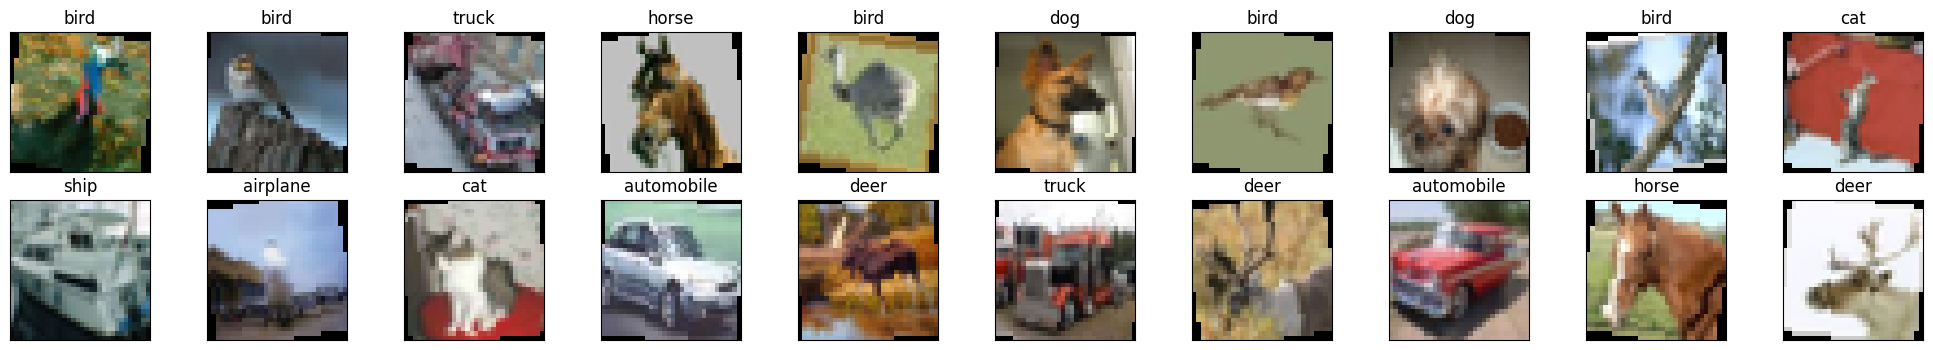

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in range(20):
  ax= fig.add_subplot(2 , int(20/2) , idx+1 , xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(class_names[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

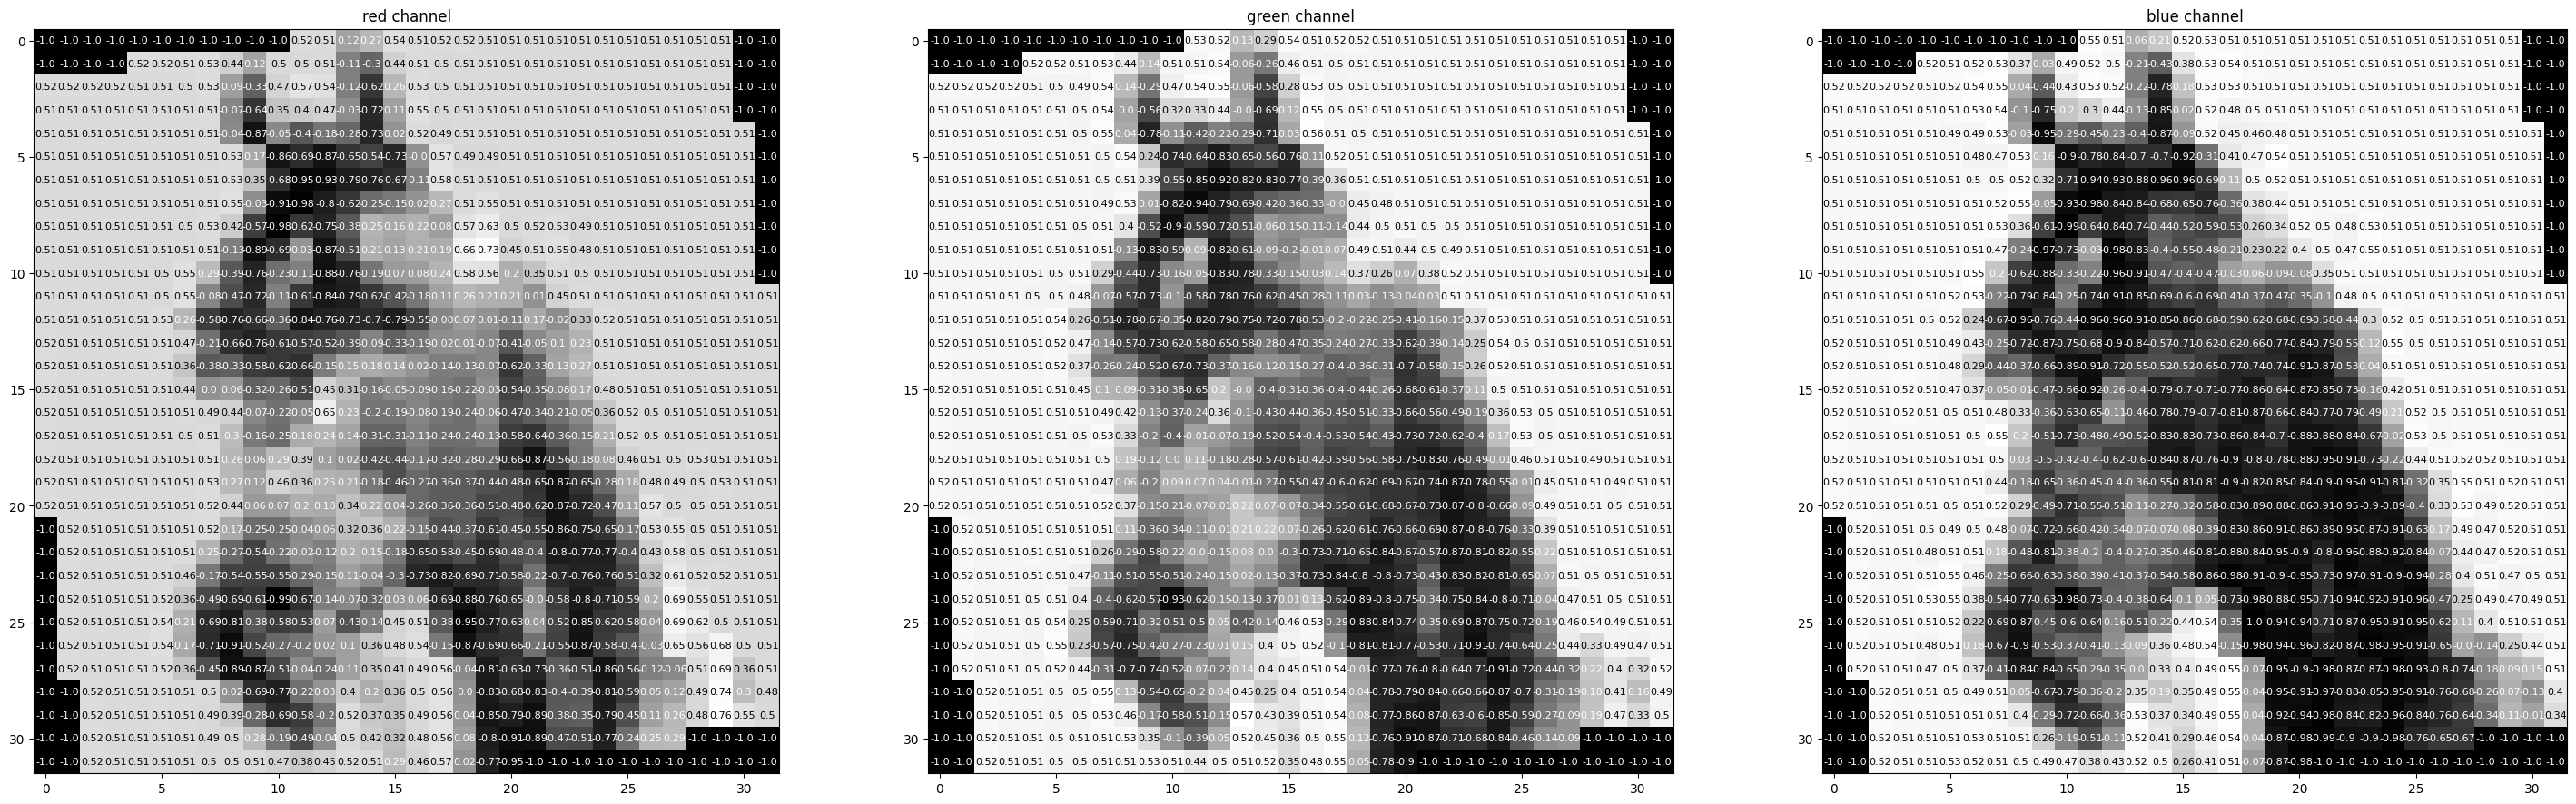

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.



<!-- <img src='notebook_ims/2_layer_conv.png' height=50% width=50% /> -->

#### TODO: Define a model with multiple convolutional layers, and define the feedforward network behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

( (W−F+2P)/S)  +  1

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # layer 1: Conv → BN → ReLU → Pool
        self.conv1 = nn.Conv2d(3, 32, 5, padding=1, stride=1) # (32 - 5 + 2(1)/ 1) + 1 = 30
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2) # (30 - 2 + 2(0)/ 2)/2 + 1 = 15

        # layer 2
        self.conv2 = nn.Conv2d(32, 32, 5, padding=1, stride=1) # (15 - 5 + 2(1)/ 1) + 1 = 13
        self.bn2   = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2) # (13 - 2 + 2(0)/ 2)/2 + 1 = 6

        # layer 3
        self.conv3 = nn.Conv2d(32, 32, 5, padding=1, stride=1) # (6 - 5 + 2(1)/ 1) + 1 = 4
        self.bn3   = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2, 2) # (4 - 2 + 2(0)/ 2)/2 + 1 = 2

        # full connection layer
        self.fc1 = nn.Linear(32 * 2**2, 120) # 3^2 size from pool3
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool1( F.relu(self.conv1(x)))
        x= self.pool2( F.relu(self.conv2(x)))
        x= self.pool3(F.relu(self.conv3(x)))
        # Flatten it
        x= torch.flatten(x, 1)
        # x = x.view(x.size(0), -1)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
def feature_calc(num_channels, k_size, stride , pad):
  calc_result=( ((num_channels - k_size + 2*pad ) / stride) + 1)
  return calc_result

In [9]:
a1=feature_calc(32, 2, 1, 1)
a2=feature_calc(np.floor(a1), 2, 2, 0)
a3=feature_calc(np.floor(a2), 2, 1, 1)
a4= feature_calc(np.floor(a3), 2, 2, 0)
a5= feature_calc(np.floor(a4), 2, 1, 0)
a6= feature_calc(np.floor(a5), 2, 2, 0)

print(a1, a2, a3, a4, a5, a6)

33.0 16.5 17.0 8.5 7.0 3.5


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [10]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr= 0.005, momentum= 0.9)


---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [11]:
# number of epochs to train the model
n_epochs = 40 # you may increase this number to train a final model
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.580711 	Validation Loss: 0.324653
Validation loss decreased (inf --> 0.324653).  Saving model ...
Epoch: 2 	Training Loss: 1.184329 	Validation Loss: 0.277396
Validation loss decreased (0.324653 --> 0.277396).  Saving model ...
Epoch: 3 	Training Loss: 1.034732 	Validation Loss: 0.238671
Validation loss decreased (0.277396 --> 0.238671).  Saving model ...
Epoch: 4 	Training Loss: 0.931476 	Validation Loss: 0.232395
Validation loss decreased (0.238671 --> 0.232395).  Saving model ...
Epoch: 5 	Training Loss: 0.851699 	Validation Loss: 0.205206
Validation loss decreased (0.232395 --> 0.205206).  Saving model ...
Epoch: 6 	Training Loss: 0.797594 	Validation Loss: 0.198588
Validation loss decreased (0.205206 --> 0.198588).  Saving model ...
Epoch: 7 	Training Loss: 0.757528 	Validation Loss: 0.192790
Validation loss decreased (0.198588 --> 0.192790).  Saving model ...
Epoch: 8 	Training Loss: 0.719933 	Validation Loss: 0.188840
Validation loss decreased (0.19279

###  Load the Model with the Lowest Validation Loss

In [12]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [17]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                class_names[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.769415

Test Accuracy of airplane: 75% (750/1000)
Test Accuracy of automobile: 87% (876/1000)
Test Accuracy of  bird: 67% (679/1000)
Test Accuracy of   cat: 65% (654/1000)
Test Accuracy of  deer: 73% (739/1000)
Test Accuracy of   dog: 55% (556/1000)
Test Accuracy of  frog: 75% (758/1000)
Test Accuracy of horse: 79% (790/1000)
Test Accuracy of  ship: 84% (848/1000)
Test Accuracy of truck: 79% (794/1000)

Test Accuracy (Overall): 74% (7444/10000)


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: 

A. The model complexity and/or **degree of fit** still have room for improvement; the present training loss has neither yet reached its minimum, nor has it arrived at the **“turning point”** where it closely approximates the validation loss.

Though the current result shows that Training Loss > Validation Loss, their final results are actually converged. Or in other word, they have nearly reached their minimum in current network, so some **extra hidden layers and more appropriate convolutional kernels** can be applied.


B. The training script requires refinement: invoking .cuda() on data and target tensors at **every iteration** incurs unnecessary overhead, however it can be hard to consider a way to solve it effectively. (Though move it out the iteration can be right, it still need be executed "2n" times.)

The logic of the training structure can be modified: we still need to apply .cuda() to data and target before entering the iterations of training, comparing the runtime and consider if there are **special** new **methods** that can solve it effectively.


C. Moreover, the combination of number of workers and batch size has not been **optimally configured**. Although the general influence of these two parameters on training performance is understood, their best values for the local environment remain unknown—excessively large values for either workers or batch size markedly **reduce training speed**, whereas an overly small batch size amplifies **noise and destabilizes convergence**. Consequently, the overall training efficiency still needs improvement.

Perhaps I can draw a chart to record their training times using an **enumeration** approach: set the number of workers to half the CPU cores of my machine and, under these conditions, measure their runtime for batch sizes of 20, 32, 64, 128, etc.


### Visualize Sample Test Results

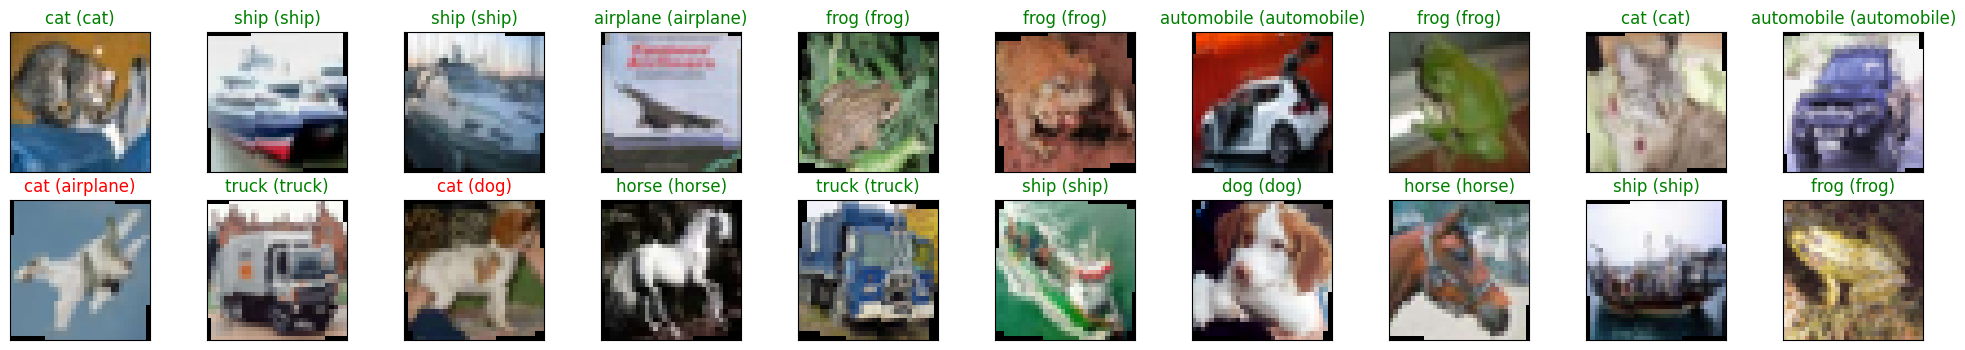

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

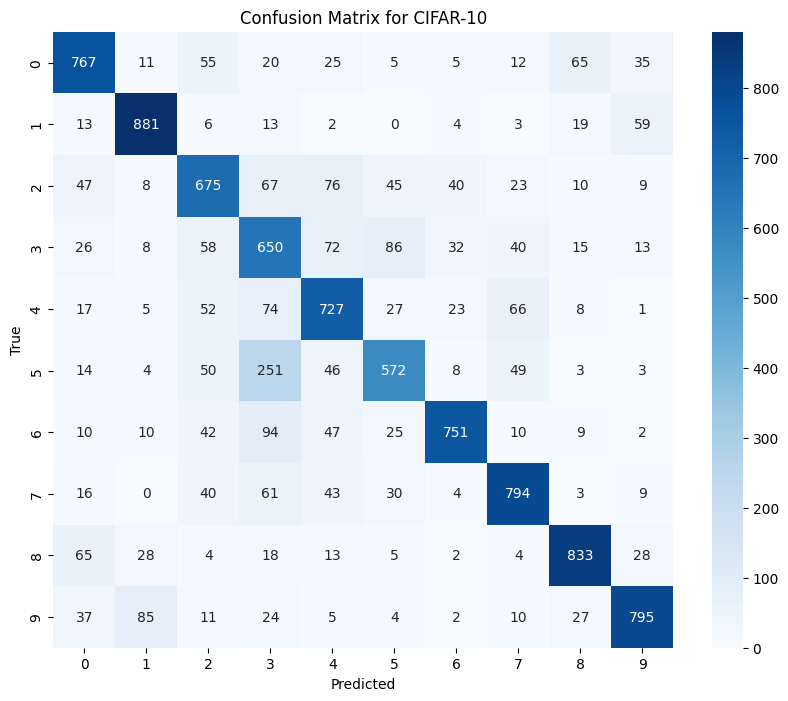

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        output = model(data)
        probs = torch.softmax(output, dim=1)
        _, pred = torch.max(probs, 1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for CIFAR-10")
plt.show()

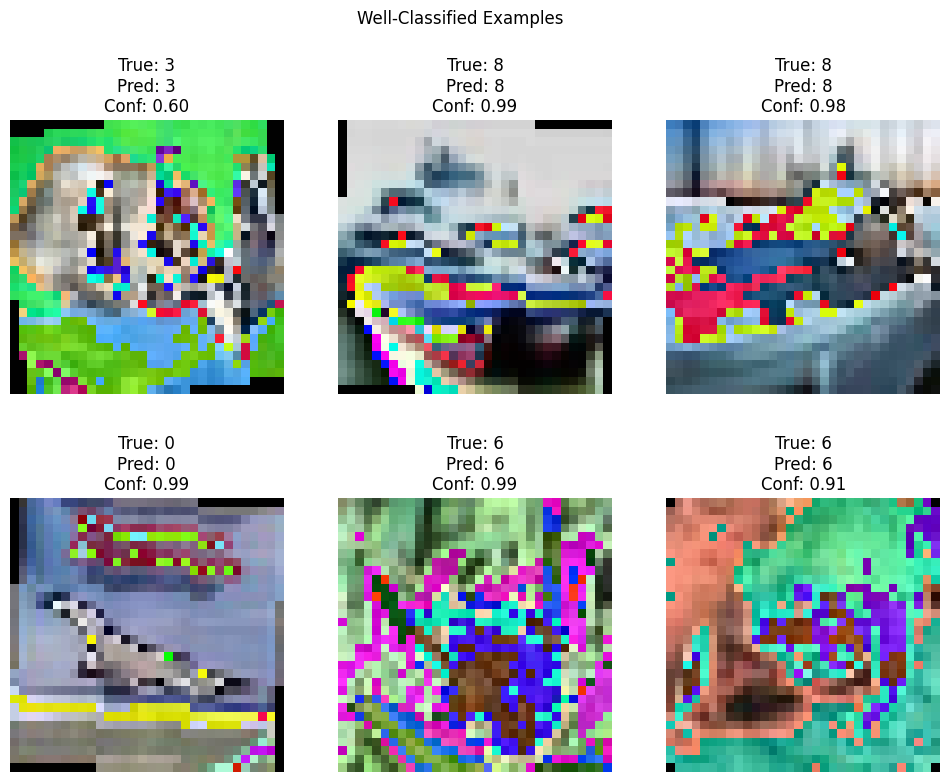

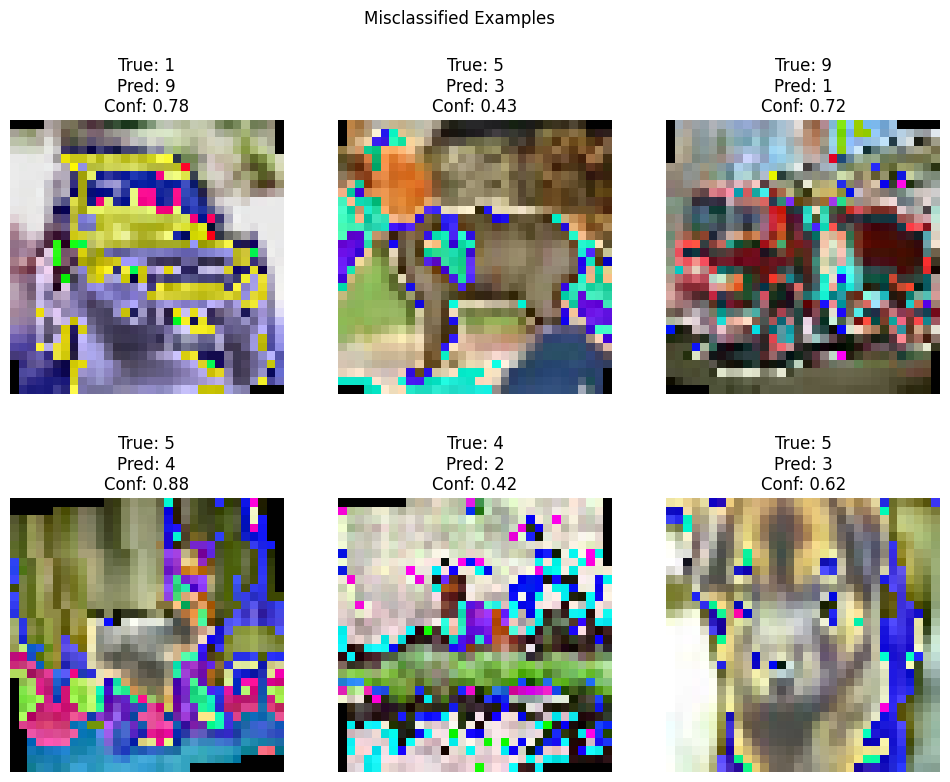

In [20]:
import torchvision.transforms.functional as tF


# Display some correct examples
def show_examples(examples, title):
    plt.figure(figsize=(12,9))
    for i in range(6):
        img, true_label, pred_label, conf = examples[i]
        img = tF.to_pil_image(img)

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}")
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

# Collect correct and incorrect examples
correct_examples = []
incorrect_examples = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        output = model(data)
        probs = torch.softmax(output, dim=1)
        confidences, preds = torch.max(probs, 1)

        for i in range(len(target)):
            img = data[i].cpu()
            true_label = target[i].item()
            pred_label = preds[i].item()
            conf = confidences[i].item()

            item = (img, true_label, pred_label, conf)

            if true_label == pred_label:
                correct_examples.append(item)
            else:
                incorrect_examples.append(item)


# Show samples
show_examples(correct_examples, "Well-Classified Examples")
show_examples(incorrect_examples, "Misclassified Examples")